In [ ]:
%%capture
%%bash

pip install --upgrade scipy flax
pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
pip install --upgrade diffusers transformers

In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from flax.jax_utils import replicate
from flax.training.common_utils import shard

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import CLIPTextModel, CLIPTokenizer

In [3]:
from transformers import CLIPFeatureExtractor, CLIPTokenizer, FlaxCLIPTextModel

In [4]:
from diffusers import FlaxAutoencoderKL, FlaxUNet2DConditionModel

In [5]:
from diffusers import (
    FlaxDDIMScheduler,
    FlaxDPMSolverMultistepScheduler,
    FlaxLMSDiscreteScheduler,
    FlaxPNDMScheduler,
)

```
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
```

`jax.numpy.float16` (on GPUs) and `jax.numpy.bfloat16` (on TPUs)

In [6]:
dtype = jax.numpy.float16

 [Flax] Add DreamBooth #1001 https://github.com/huggingface/diffusers/pull/1001 `duongna/stable-diffusion-v1-4-flax`

In [7]:
model_id = "CompVis/stable-diffusion-v1-4"

In [8]:
tokenizer = CLIPTokenizer.from_pretrained(model_id, revision="flax", subfolder="tokenizer", dtype=dtype)
text_encoder = FlaxCLIPTextModel.from_pretrained(model_id, revision="flax", subfolder="text_encoder", dtype=dtype)

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [9]:
vae, vae_params = FlaxAutoencoderKL.from_pretrained(model_id, revision="flax", subfolder="vae", dtype=dtype)
unet, unet_params = FlaxUNet2DConditionModel.from_pretrained(model_id, revision="flax", subfolder="unet", dtype=dtype)

/usr/local/lib/python3.7/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.
  warnings.warn(warning + message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  warnings.warn(warning + message, FutureWarning)


In [10]:
prompt = "a photo of an astronaut riding a horse on mars"

In [11]:
token_ids = tokenizer.encode(prompt)

In [12]:
token_ids

[49406, 320, 1125, 539, 550, 18376, 6765, 320, 4558, 525, 7496, 49407]

In [13]:
tokenizer.decode(49406), tokenizer.decode(49407)

('<|startoftext|>', '<|endoftext|>')

In [14]:
text_input = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )

In [15]:
text_input.input_ids

array([[49406,   320,  1125,   539,   550, 18376,  6765,   320,  4558,
          525,  7496, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407]])

```
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()
text_embeddings.shape
```

In [16]:
# get prompt text embeddings
text_embeddings = text_encoder(text_input.input_ids)[0]

In [17]:
"DEBUG", text_embeddings.shape

('DEBUG', (1, 77, 768))

In [18]:
batch_size, max_length = text_input.input_ids.shape[0], text_input.input_ids.shape[-1]
vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)

In [19]:
"DEBUG", batch_size, max_length, vae_scale_factor

('DEBUG', 1, 77, 8)

In [20]:
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=max_length,
    return_tensors="np"
)

uncond_input = uncond_input.input_ids

In [21]:
uncond_embeddings = text_encoder(uncond_input)[0]

In [22]:
"DEBUG", uncond_embeddings.shape

('DEBUG', (1, 77, 768))

In [23]:
context = jnp.concatenate([uncond_embeddings, text_embeddings])

In [24]:
"DEBUG", context.shape

('DEBUG', (2, 77, 768))

In [25]:
height = unet.config.sample_size * vae_scale_factor
width = unet.config.sample_size * vae_scale_factor

latents_shape = (
            batch_size,
            unet.in_channels,
            height // vae_scale_factor,
            width // vae_scale_factor,
        )

prng_seed = jax.random.PRNGKey(0)

In [26]:
"DEBUG", height, width, latents_shape, prng_seed

('DEBUG', 512, 512, (1, 4, 64, 64), DeviceArray([0, 0], dtype=uint32))

In [27]:
latents = jax.random.normal(prng_seed, shape=latents_shape, dtype=dtype)

In [28]:
"DEBUG", latents.shape

('DEBUG', (1, 4, 64, 64))

In [29]:
guidance_scale = 7.5 #@param {type:"slider", min:0, max:100, step:0.5}
num_inference_steps = 30 #@param

In [30]:
from diffusers.schedulers.scheduling_pndm_flax import PNDMSchedulerState
import pdb

In [31]:
def diffusion_step(step, args):
    latents, scheduler_state = args
    # For classifier free guidance, we need to do two forward passes.
    # Here we concatenate the unconditional and text embeddings into a single batch
    # to avoid doing two forward passes
    latents_input = jnp.concatenate([latents] * 2)

    t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
    timestep = jnp.broadcast_to(t, latents_input.shape[0])

    latents_input = scheduler.scale_model_input(scheduler_state, latents_input, t)

    # predict the noise residual
    noise_pred = unet.apply(
        {"params": unet_params},
        jnp.array(latents_input),
        jnp.array(timestep, dtype=jnp.int32),
        encoder_hidden_states=context,
        ).sample
    # perform guidance
    noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    # run(state=scheduler_state, model_output=noise_pred, sample=latents)
    
    latents, scheduler_state = scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()
    return latents, scheduler_state


```python
scheduler, scheduler_params = FlaxPNDMScheduler.from_pretrained(model_id, revision="flax", subfolder="scheduler")
scheduler_state = scheduler.set_timesteps(
    scheduler_params, num_inference_steps=num_inference_steps, shape=latents.shape
    )
# scale the initial noise by the standard deviation required by the scheduler
latents = latents * scheduler.init_noise_sigma
"DEBUG", latents.shape
```

In [32]:
from dataclasses import dataclass
from typing import Optional, Tuple, Union
from scipy import integrate
from diffusers.schedulers.scheduling_utils_flax import (
    _FLAX_COMPATIBLE_STABLE_DIFFUSION_SCHEDULERS,
    FlaxSchedulerMixin,
    FlaxSchedulerOutput,
    broadcast_to_shape_from_left,
)
from diffusers.schedulers.scheduling_lms_discrete_flax import LMSDiscreteSchedulerState, FlaxLMSSchedulerOutput
from diffusers.configuration_utils import ConfigMixin, register_to_config

class FlaxLMSDiscreteScheduler(FlaxSchedulerMixin, ConfigMixin):
    """
    Linear Multistep Scheduler for discrete beta schedules. Based on the original k-diffusion implementation by
    Katherine Crowson:
    https://github.com/crowsonkb/k-diffusion/blob/481677d114f6ea445aa009cf5bd7a9cdee909e47/k_diffusion/sampling.py#L181

    [`~ConfigMixin`] takes care of storing all config attributes that are passed in the scheduler's `__init__`
    function, such as `num_train_timesteps`. They can be accessed via `scheduler.config.num_train_timesteps`.
    [`SchedulerMixin`] provides general loading and saving functionality via the [`SchedulerMixin.save_pretrained`] and
    [`~SchedulerMixin.from_pretrained`] functions.

    Args:
        num_train_timesteps (`int`): number of diffusion steps used to train the model.
        beta_start (`float`): the starting `beta` value of inference.
        beta_end (`float`): the final `beta` value.
        beta_schedule (`str`):
            the beta schedule, a mapping from a beta range to a sequence of betas for stepping the model. Choose from
            `linear` or `scaled_linear`.
        trained_betas (`jnp.ndarray`, optional):
            option to pass an array of betas directly to the constructor to bypass `beta_start`, `beta_end` etc.
    """

    _compatibles = _FLAX_COMPATIBLE_STABLE_DIFFUSION_SCHEDULERS.copy()

    @property
    def has_state(self):
        return True

    @register_to_config
    def __init__(
        self,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        beta_schedule: str = "linear",
        trained_betas: Optional[jnp.ndarray] = None,
    ):
        if trained_betas is not None:
            self.betas = jnp.asarray(trained_betas)
        elif beta_schedule == "linear":
            self.betas = jnp.linspace(beta_start, beta_end, num_train_timesteps, dtype=jnp.float32)
        elif beta_schedule == "scaled_linear":
            # this schedule is very specific to the latent diffusion model.
            self.betas = jnp.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=jnp.float32) ** 2
        else:
            raise NotImplementedError(f"{beta_schedule} does is not implemented for {self.__class__}")

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = jnp.cumprod(self.alphas, axis=0)

    def create_state(self):
        self.state = LMSDiscreteSchedulerState.create(
            num_train_timesteps=self.config.num_train_timesteps,
            sigmas=((1 - self.alphas_cumprod) / self.alphas_cumprod) ** 0.5,
        )

    def scale_model_input(
        self, state: LMSDiscreteSchedulerState, sample: jnp.ndarray, timestep: int
    ) -> jnp.ndarray:
        """
        Scales the denoising model input by `(sigma**2 + 1) ** 0.5` to match the K-LMS algorithm.

        Args:
            sample (`torch.FloatTensor`): input sample
            timestep (`float` or `torch.FloatTensor`): the current timestep in the diffusion chain

        Returns:
            `torch.FloatTensor`: scaled input sample
        """
        step_index, = jnp.where(scheduler_state.timesteps == timestep, size=1)
        sigma = scheduler_state.sigmas[step_index]
        sample = sample / ((sigma**2 + 1) ** 0.5)
        # if isinstance(timestep, torch.Tensor):
        #     timestep = timestep.to(self.timesteps.device)
        # step_index = (state.timesteps == timestep).nonzero().item()
        # sigma = self.sigmas[step_index]
        # self.is_scale_input_called = True
        return sample

    def get_lms_coefficient(self, state, order, t, current_order):
        """
        Compute a linear multistep coefficient.

        Args:
            order (TODO):
            t (TODO):
            current_order (TODO):
        """

        def lms_derivative(tau):
            prod = 1.0
            for k in range(order):
                if current_order == k:
                    continue
                prod *= (tau - state.sigmas[t - k]) / (state.sigmas[t - current_order] - state.sigmas[t - k])
            return prod

        integrated_coeff = integrate.quad(lms_derivative, state.sigmas[t], state.sigmas[t + 1], epsrel=1e-4)[0]

        return integrated_coeff

    def set_timesteps(
        self, state: LMSDiscreteSchedulerState, num_inference_steps: int, shape: Tuple = ()
    ) -> LMSDiscreteSchedulerState:
        """
        Sets the timesteps used for the diffusion chain. Supporting function to be run before inference.

        Args:
            state (`LMSDiscreteSchedulerState`):
                the `FlaxLMSDiscreteScheduler` state data class instance.
            num_inference_steps (`int`):
                the number of diffusion steps used when generating samples with a pre-trained model.
        """
        timesteps = jnp.linspace(self.config.num_train_timesteps - 1, 0, num_inference_steps, dtype=jnp.float32)

        low_idx = jnp.floor(timesteps).astype(int)
        high_idx = jnp.ceil(timesteps).astype(int)
        frac = jnp.mod(timesteps, 1.0)
        sigmas = jnp.array(((1 - self.alphas_cumprod) / self.alphas_cumprod) ** 0.5)
        sigmas = (1 - frac) * sigmas[low_idx] + frac * sigmas[high_idx]
        sigmas = jnp.concatenate([sigmas, jnp.array([0.0])]).astype(jnp.float32)

        return state.replace(
            num_inference_steps=num_inference_steps,
            timesteps=timesteps.astype(int),
            derivatives=jnp.array([]),
            sigmas=sigmas,
        )

    def step(
        self,
        state: LMSDiscreteSchedulerState,
        model_output: jnp.ndarray,
        timestep: int,
        sample: jnp.ndarray,
        order: int = 4,
        return_dict: bool = True,
    ) -> Union[FlaxLMSSchedulerOutput, Tuple]:
        """
        Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            state (`LMSDiscreteSchedulerState`): the `FlaxLMSDiscreteScheduler` state data class instance.
            model_output (`jnp.ndarray`): direct output from learned diffusion model.
            timestep (`int`): current discrete timestep in the diffusion chain.
            sample (`jnp.ndarray`):
                current instance of sample being created by diffusion process.
            order: coefficient for multi-step inference.
            return_dict (`bool`): option for returning tuple rather than FlaxLMSSchedulerOutput class

        Returns:
            [`FlaxLMSSchedulerOutput`] or `tuple`: [`FlaxLMSSchedulerOutput`] if `return_dict` is True, otherwise a
            `tuple`. When returning a tuple, the first element is the sample tensor.

        """
        sigma = state.sigmas[timestep]

        # 1. compute predicted original sample (x_0) from sigma-scaled predicted noise
        pred_original_sample = sample - sigma * model_output

        # 2. Convert to an ODE derivative
        derivative = (sample - pred_original_sample) / sigma
        state = state.replace(derivatives=jnp.append(state.derivatives, derivative))
        if len(state.derivatives) > order:
            state = state.replace(derivatives=jnp.delete(state.derivatives, 0))

        # 3. Compute linear multistep coefficients
        order = min(timestep + 1, order)
        lms_coeffs = [self.get_lms_coefficient(state, order, timestep, curr_order) for curr_order in range(order)]

        # 4. Compute previous sample based on the derivatives path
        prev_sample = sample + sum(
            coeff * derivative for coeff, derivative in zip(lms_coeffs, reversed(state.derivatives))
        )

        if not return_dict:
            return (prev_sample, state)

        return FlaxLMSSchedulerOutput(prev_sample=prev_sample, state=state)

    def add_noise(
        self,
        state: LMSDiscreteSchedulerState,
        original_samples: jnp.ndarray,
        noise: jnp.ndarray,
        timesteps: jnp.ndarray,
    ) -> jnp.ndarray:
        sigma = state.sigmas[timesteps].flatten()
        sigma = broadcast_to_shape_from_left(sigma, noise.shape)

        noisy_samples = original_samples + noise * sigma

        return noisy_samples

    def __len__(self):
        return self.config.num_train_timesteps


In [33]:
scheduler = FlaxLMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=num_inference_steps
)

In [34]:
scheduler.create_state()
scheduler_state = scheduler.set_timesteps(
    scheduler.state, num_inference_steps=num_inference_steps, shape=latents.shape
    )

scheduler.init_noise_sigma = scheduler_state.sigmas.max()

In [35]:
scheduler_state.timesteps

DeviceArray([29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 14,
             14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  1,  1,  0],            dtype=int32)

In [36]:
scheduler_state.sigmas

DeviceArray([0.41958162, 0.40241283, 0.38560292, 0.36914125, 0.35301813,
             0.33722416, 0.32175076, 0.30658963, 0.2917331 , 0.27717403,
             0.26290518, 0.24892011, 0.23521225, 0.22177525, 0.20860268,
             0.19568811, 0.18302433, 0.17060375, 0.15841734, 0.14645454,
             0.13470238, 0.12314408, 0.11175691, 0.10050948, 0.08935619,
             0.07822697, 0.06700747, 0.05549441, 0.04326575, 0.02916753,
             0.        ], dtype=float32)

```
# run with python for loop
for i in range(num_inference_steps):
    latents, scheduler_state = diffusion_step(i, (latents, scheduler_state))
```

```
# run with Jax loop (much faster)
latents, _ = jax.lax.fori_loop(0, num_inference_steps, diffusion_step, (latents, scheduler_state))
```

In [37]:
from tqdm import tqdm

In [38]:
for i in tqdm(range(num_inference_steps)):
    latents, scheduler_state = diffusion_step(i, (latents, scheduler_state))

100%|██████████| 30/30 [33:25<00:00, 66.85s/it]


In [39]:
# latents, _ = jax.lax.fori_loop(0, num_inference_steps, diffusion_step, (latents, scheduler_state))

In [40]:
saved_latents = latents

In [41]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
image = vae.apply({"params": vae_params}, latents, method=vae.decode).sample

image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)

In [42]:
from diffusers import FlaxDiffusionPipeline

```
images = FlaxDiffusionPipeline.numpy_to_pil(np.asarray(images.reshape((num_samples,) + images.shape[-3:])))
```

In [43]:
images = image
images.shape, images.reshape((1,) + images.shape[-3:]).shape

((1, 512, 512, 3), (1, 512, 512, 3))

In [44]:
images = image
images = FlaxDiffusionPipeline.numpy_to_pil(np.asarray(images.reshape((1,) + images.shape[-3:])))

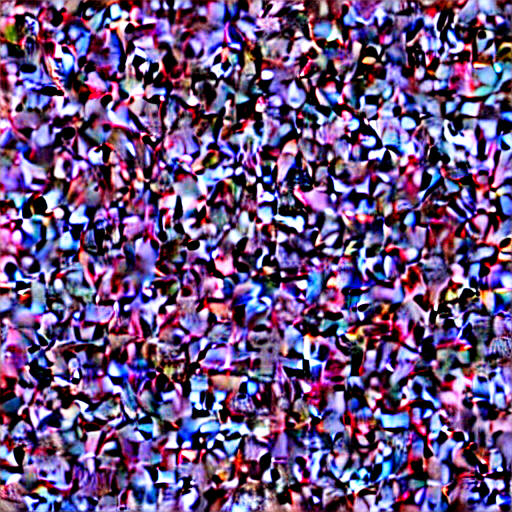

In [45]:
images[0]

## Noise scheduling

```
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)
```

In [ ]:
scheduler = FlaxLMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
)

In [ ]:
scheduler.create_state()

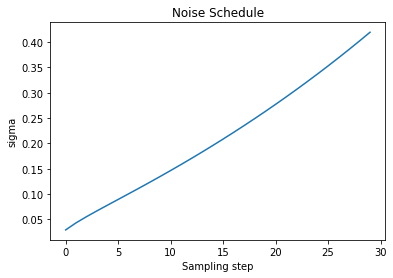

In [ ]:
# Plotting this noise schedule:
plt.plot(scheduler.state.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()